## Learning Objectives
At the end of the experiment, you will be able to :

* perform data preprocessing
* perform feature transformation
* implement CatBoost, XGBoost and LightGBM model to perform classification using Lending Club dataset

## Introduction

**XGBoost** was originally produced by University of Washington researchers and is maintained by open-source contributors. XGBoost is available in Python, R, Java, Ruby, Swift, Julia, C, and C++. Similar to LightGBM, XGBoost uses the gradients of different cuts to select the next cut, but XGBoost also uses the hessian, or second derivative, in its ranking of cuts. Computing this next derivative comes at a slight cost, but it also allows a greater estimation of the cut to use.

**CatBoost** is developed and maintained by the Russian search engine Yandex and is available in Python, R, C++, Java, and also Rust. CatBoost distinguishes itself from LightGBM and XGBoost by focusing on optimizing decision trees for categorical variables, or variables whose different values may have no relation with each other (eg. apples and oranges).

**LightGBM** is a boosting technique and framework developed by Microsoft. The framework implements the LightGBM algorithm and is available in Python, R, and C. LightGBM is unique in that it can construct trees using Gradient-Based One-Sided Sampling, or GOSS for short.

To know more on comparisons between CatBoost, XgBoost and LightGBM, refer below
- [Article 1](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
- [Article 2](https://towardsdatascience.com/catboost-vs-lightgbm-vs-xgboost-c80f40662924)

## Dataset Description

Lending Club is a lending platform that lends money to people in need at an interest rate based on their credit history and other factors. We will analyze this data and pre-process it based on our need and build a machine learning model that can identify a potential defaulter based on his/her history of transactions with Lending Club.

This dataset contains 42538 rows and 144 columns. **Out of these 144 columns, many columns have majorly null values.**

To know more about the Lending Club dataset features, refer [here](https://www.openintro.org/data/index.php?data=loans_full_schema).

###  Import required packages

In [1]:
!pip -qq install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Load Dataset

In [16]:
# Load the raw loan stats dataset
data = pd.read_csv("LoanStats3a.csv")
data.shape

(42538, 144)

## Data Preprocessing

In [17]:
# View the top 5 rows of data
pd.set_option('display.max_columns', None)

data.head(5)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62,NaN,Jul-18,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66,NaN,Oct-16,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,NaN,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.50%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,

In [18]:
# Size of the dataset
data.shape

(42538, 144)

In [19]:
# Checking info of the raw dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Columns: 144 entries, member_id to settlement_term
dtypes: float64(115), object(29)
memory usage: 46.7+ MB


### Check for missing values in the dataset

In [20]:
# Check missing values
data.isnull().sum()

,0
member_id,42538
loan_amnt,3
funded_amnt,3
funded_amnt_inv,3
term,3
...,...
settlement_status,42378
settlement_date,42378
settlement_amount,42378
settlement_percentage,42378


In [21]:
# Total percentage of null values in the data
pct = (data.isnull().sum().sum())/(data.shape[0]*data.shape[1])
print("Overall missing values in the data ≈ {:.2f} %".format(pct*100))

Overall missing values in the data ≈ 62.44 %


In [22]:
print(data.head())

   member_id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0        NaN     5000.0       5000.0           4975.0   36 months   10.65%   
1        NaN     2500.0       2500.0           2500.0   60 months   15.27%   
2        NaN     2400.0       2400.0           2400.0   36 months   15.96%   
3        NaN    10000.0      10000.0          10000.0   36 months   13.49%   
4        NaN     3000.0       3000.0           3000.0   60 months   12.69%   

   installment grade sub_grade                 emp_title emp_length  \
0       162.87     B        B2                       NaN  10+ years   
1        59.83     C        C4                     Ryder   < 1 year   
2        84.33     C        C5                       NaN  10+ years   
3       339.31     C        C1       AIR RESOURCES BOARD  10+ years   
4        67.79     B        B5  University Medical Group     1 year   

  home_ownership  annual_inc verification_status issue_d  loan_status  \
0           RENT     24000.0   

From above we can see that, about 63% of the values in the overall data are null values.

Let's visualize the null values using the heatmap.

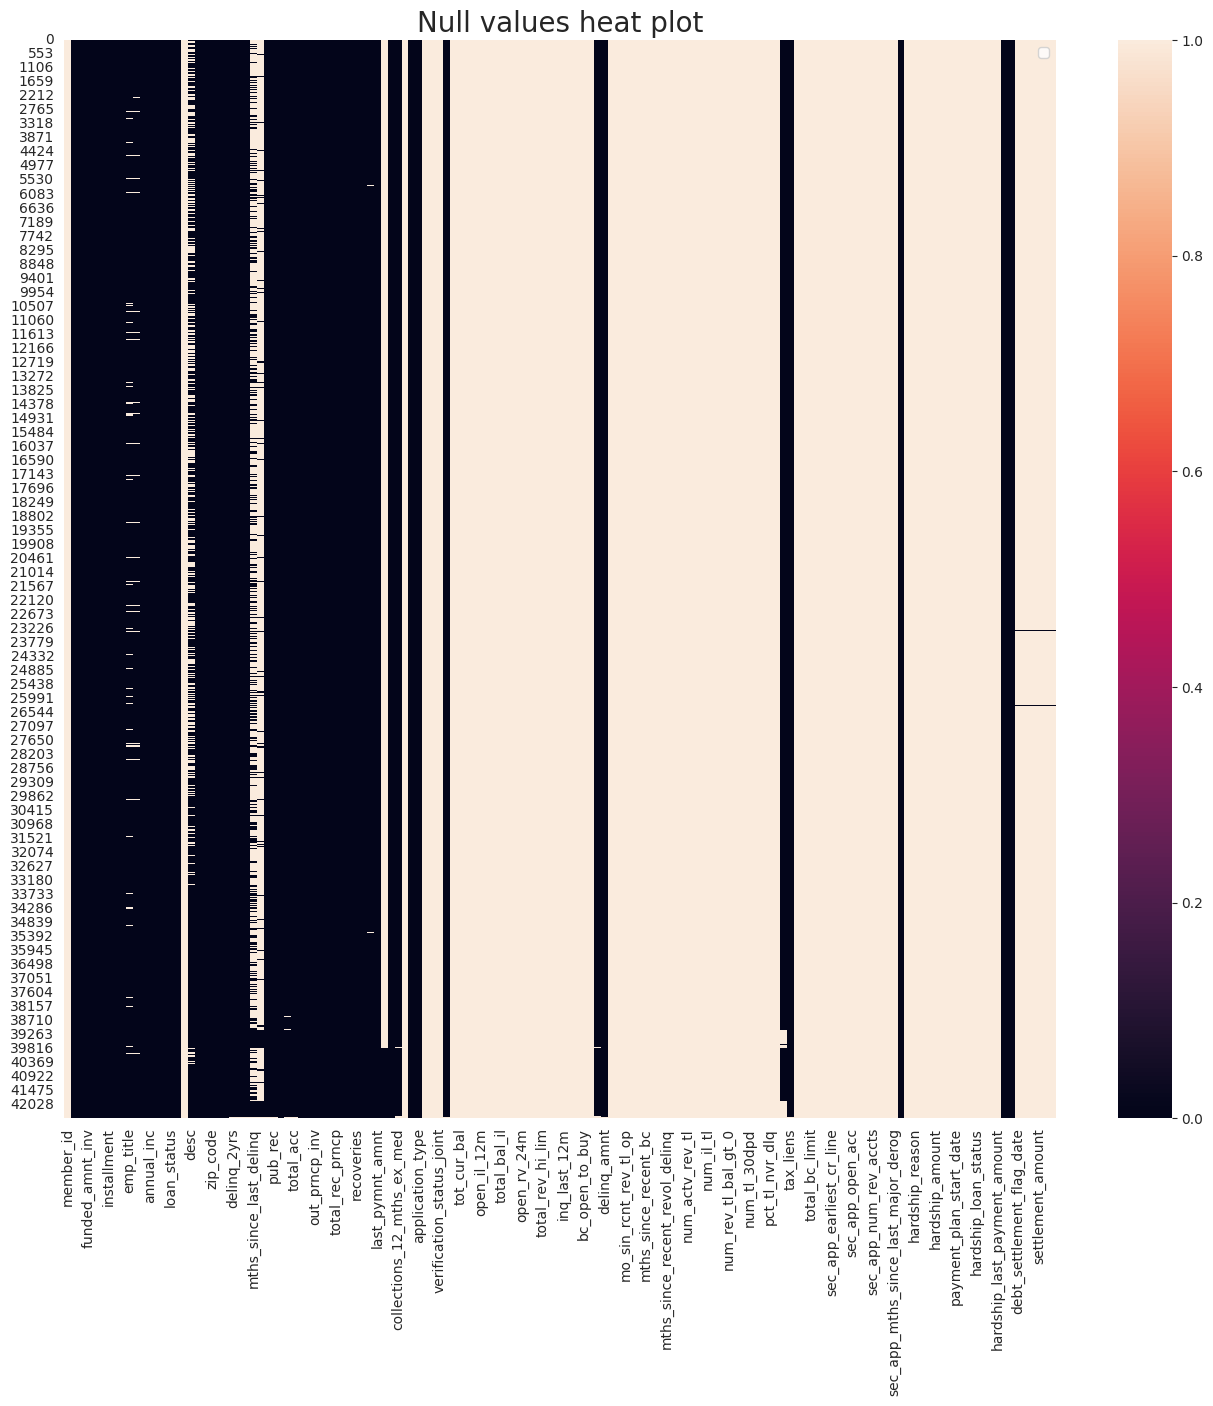

In [23]:
# Checking for null values using a heatmap as a visualizing tool
plt.figure(figsize=(16,14))
sns.heatmap(data.isnull())
plt.title('Null values heat plot', fontdict={'fontsize': 20})
plt.legend(data.isnull())
plt.show()

As we can see from the above heatmap, there are lot of null values in the dataset. We have to carefully deal with these null values.

### Handling missing values in the data

- Select columns having null values less than 40%

In [25]:
''' Creating a dataframe to display percentage of null values in different number of columns
temp_df = pd.DataFrame()
temp_df['Percentage of null values'] = ['10% or less', '10% to 20%', '20% to 30%', '30% to 40%', '40% to 50%',
                                        '50% to 60%', '60% to 70%', '70% to 80%', '80% to 90%', 'More than 90%']

# Store the columns count separately for each range
ten_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.1])
ten_to_twenty_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.2] & data.columns[((data.isnull().sum())/len(data)) > 0.1])
twenty_to_thirty_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.3] & data.columns[((data.isnull().sum())/len(data)) > 0.2])
thirty_to_forty_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.4] & data.columns[((data.isnull().sum())/len(data)) > 0.3])
forty_to_fifty_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.5] & data.columns[((data.isnull().sum())/len(data)) > 0.4])
fifty_to_sixty_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.6] & data.columns[((data.isnull().sum())/len(data)) > 0.5])
sixty_to_seventy_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.7] & data.columns[((data.isnull().sum())/len(data)) > 0.6])
seventy_to_eighty_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.8] & data.columns[((data.isnull().sum())/len(data)) > 0.7])
eighty_to_ninety_percent = len(data.columns[((data.isnull().sum())/len(data)) <= 0.9] & data.columns[((data.isnull().sum())/len(data)) > 0.8])
hundred_percent = len(data.columns[((data.isnull().sum())/len(data)) > 0.9])

temp_df['No. of columns'] = [ten_percent, ten_to_twenty_percent, twenty_to_thirty_percent, thirty_to_forty_percent, forty_to_fifty_percent,
                             fifty_to_sixty_percent, sixty_to_seventy_percent, seventy_to_eighty_percent, eighty_to_ninety_percent, hundred_percent]
temp_df'''

temp_df = pd.DataFrame()
temp_df['Percentage of null values'] = ['10% or less', '10% to 20%', '20% to 30%', '30% to 40%', '40% to 50%',
                                        '50% to 60%', '60% to 70%', '70% to 80%', '80% to 90%', 'More than 90%']

# Calculate the percentage of null values for each column
null_percentages = (data.isnull().sum()) / len(data)

# Store the columns count separately for each range
ten_percent = len(null_percentages[null_percentages <= 0.1])
ten_to_twenty_percent = len(null_percentages[(null_percentages <= 0.2) & (null_percentages > 0.1)])  # Corrected logic
twenty_to_thirty_percent = len(null_percentages[(null_percentages <= 0.3) & (null_percentages > 0.2)])  # Corrected logic
thirty_to_forty_percent = len(null_percentages[(null_percentages <= 0.4) & (null_percentages > 0.3)])  # Corrected logic
forty_to_fifty_percent = len(null_percentages[(null_percentages <= 0.5) & (null_percentages > 0.4)])  # Corrected logic
fifty_to_sixty_percent = len(null_percentages[(null_percentages <= 0.6) & (null_percentages > 0.5)])  # Corrected logic
sixty_to_seventy_percent = len(null_percentages[(null_percentages <= 0.7) & (null_percentages > 0.6)])  # Corrected logic
seventy_to_eighty_percent = len(null_percentages[(null_percentages <= 0.8) & (null_percentages > 0.7)])  # Corrected logic
eighty_to_ninety_percent = len(null_percentages[(null_percentages <= 0.9) & (null_percentages > 0.8)])  # Corrected logic
hundred_percent = len(null_percentages[null_percentages > 0.9])  # Corrected logic


temp_df['No. of columns'] = [ten_percent, ten_to_twenty_percent, twenty_to_thirty_percent, thirty_to_forty_percent, forty_to_fifty_percent,
                             fifty_to_sixty_percent, sixty_to_seventy_percent, seventy_to_eighty_percent, eighty_to_ninety_percent, hundred_percent]
temp_df

,Percentage of null values,No. of columns
0,10% or less,53
1,10% to 20%,0
2,20% to 30%,0
3,30% to 40%,1
4,40% to 50%,0
5,50% to 60%,0
6,60% to 70%,1
7,70% to 80%,0
8,80% to 90%,0
9,More than 90%,89


From the above results, we can see that there are only 53 columns out of 144 columns that have null values less than 40%.

In [26]:
# Considering only those columns which have null values less than 40% in that particular column
df1 = data[data.columns[((data.isnull().sum())/len(data)) < 0.4]]
df1.shape

(42538, 54)

By considering columns with less number of null values, we were able to decrease total number of columns from 144 to 53.

Note that we will deal with null values present in these selected 53 columns later below.

### Removing columns having single distinct value

In [27]:
# Checking columns that have only single values in them i.e, constant columns
const_cols = []
for i in df1.columns:
    if df1[i].nunique() == 1:
        const_cols.append(i)

print(const_cols)

['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'chargeoff_within_12_mths', 'hardship_flag', 'disbursement_method']


In [28]:
# After observing the above output, we are dropping columns which have single values in them
print("Shape before:", df1.shape)
df1.drop(const_cols, axis=1, inplace = True)
print("Shape after:", df1.shape)

Shape before: (42538, 54)
Shape after: (42538, 44)


### Extract features from datetime columns

In [29]:
# Columns other than numerical value
colms = df1.columns[df1.dtypes == 'object']
colms

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d',
       'debt_settlement_flag'],
      dtype='object')

In [30]:
# Check which columns needs to be converted to datetime
df1[colms].head(2)

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,last_pymnt_d,last_credit_pull_d,debt_settlement_flag
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,Jan-15,Jul-18,N
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,9.40%,Apr-13,Oct-16,N


In [31]:
# Converting objects to datetime columns
dt_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for i in dt_cols:
    df1[i] = pd.to_datetime(df1[i].astype('str'), format='%b-%y', yearfirst=False)

In [32]:
# Checking the new datetime columns
df1[['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,2018-07-01
1,2011-12-01,1999-04-01,2013-04-01,2016-10-01
2,2011-12-01,2001-11-01,2014-06-01,2017-06-01
3,2011-12-01,1996-02-01,2015-01-01,2016-04-01
4,2011-12-01,1996-01-01,2017-01-01,2018-04-01


In [33]:
# Considering only year of joining for 'earliest_cr_line' column
df1['earliest_cr_line'] = pd.DatetimeIndex(df1['earliest_cr_line']).year

In [34]:
# Adding new features by getting month and year from [issue_d, last_pymnt_d, and last_credit_pull_d] columns
df1['issue_d_year'] = pd.DatetimeIndex(df1['issue_d']).year
df1['issue_d_month'] = pd.DatetimeIndex(df1['issue_d']).month
df1['last_pymnt_d_year'] = pd.DatetimeIndex(df1['last_pymnt_d']).year
df1['last_pymnt_d_month'] = pd.DatetimeIndex(df1['last_pymnt_d']).month
df1['last_credit_pull_d_year'] = pd.DatetimeIndex(df1['last_credit_pull_d']).year
df1['last_credit_pull_d_month'] = pd.DatetimeIndex(df1['last_credit_pull_d']).month

In [35]:
# Feature extraction
df1.earliest_cr_line = 2019 - (df1.earliest_cr_line)
df1.issue_d_year = 2019 - (df1.issue_d_year)
df1.last_pymnt_d_year = 2019 - (df1.last_pymnt_d_year)
df1.last_credit_pull_d_year = 2019 - (df1.last_credit_pull_d_year)

In [36]:
# Dropping the original features to avoid data redundancy
df1.drop(['issue_d','last_pymnt_d','last_credit_pull_d'], axis=1, inplace=True)
df1.shape

(42538, 47)

### Check for missing values in reduced dataset

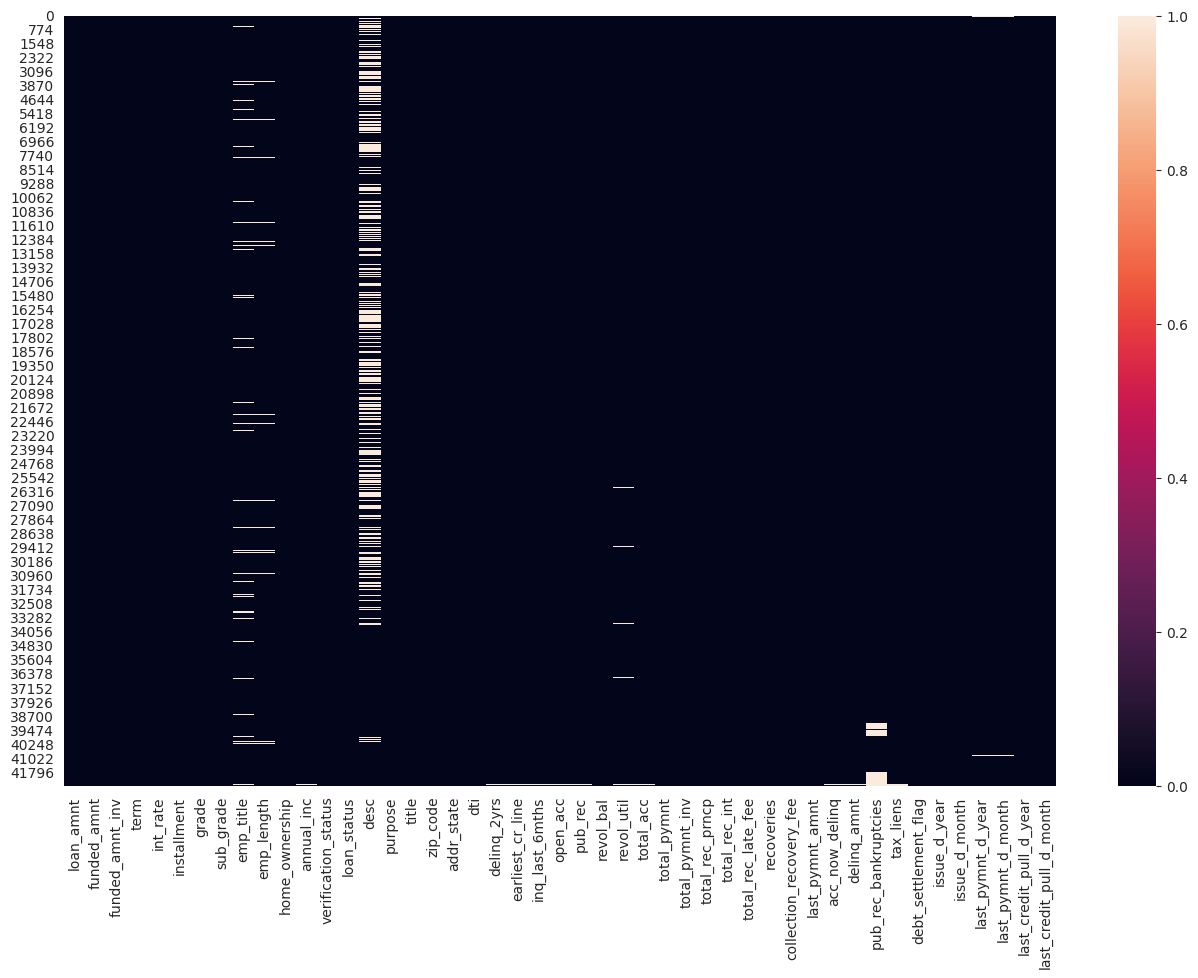

In [37]:
# Checking for null values in the updated dataframe
plt.figure(figsize=(16,10))
sns.heatmap(df1.isnull())
plt.show()

### Handling Null values in reduced dataset

In [38]:
# Checking for Percentage of null values
a = (df1.isnull().sum() / df1.shape[0]) * 100
b = a[a > 0.00]
b = pd.DataFrame(b, columns = ['Percentage of null values'])
b.sort_values(by= ['Percentage of null values'], ascending=False)

,Percentage of null values
desc,31.261460
emp_title,6.180356
pub_rec_bankruptcies,3.215948
emp_length,2.621186
tax_liens,0.253891
revol_util,0.218628
last_pymnt_d_month,0.202172
last_pymnt_d_year,0.202172
total_acc,0.075227
inq_last_6mths,0.075227


In [39]:
# Dropping the 29 rows which have null values in few columns
df1 = df1[df1['delinq_2yrs'].notnull()]
df1.shape

(42506, 47)

In [40]:
# Checking again for Percentage of null values
a = (df1.isnull().sum() / df1.shape[0]) * 100
b = a[a > 0.00]
b = pd.DataFrame(b, columns = ['Percentage of null values'])
b.sort_values(by= ['Percentage of null values'], ascending=False)

,Percentage of null values
desc,31.275585
emp_title,6.149720
pub_rec_bankruptcies,3.143086
emp_length,2.616101
last_pymnt_d_year,0.195267
last_pymnt_d_month,0.195267
tax_liens,0.178798
revol_util,0.143509
title,0.030584
last_credit_pull_d_year,0.007058


Now, imputing the missing values with the median value for columns **'last_pymnt_d_year', 'last_pymnt_d_month', 'last_credit_pull_d_year', 'last_credit_pull_d_month', 'tax_liens'** as null values in these columns are less than 0.5% of the size.

In [41]:
# Imputing the null values with the median value
df1['last_pymnt_d_year'].fillna(df1['last_pymnt_d_year'].median(), inplace=True)
df1['last_pymnt_d_month'].fillna(df1['last_pymnt_d_month'].median(), inplace=True)
df1['last_credit_pull_d_year'].fillna(df1['last_credit_pull_d_year'].median(), inplace=True)
df1['last_credit_pull_d_month'].fillna(df1['last_credit_pull_d_month'].median(), inplace=True)
df1['tax_liens'].fillna(df1['tax_liens'].median(), inplace=True)

For **'revol_util'** column, filling null values with median(string) which is close to 50:

In [42]:
# For 'revol_util' column, fill null values with 50%
df1.revol_util.fillna('50%', inplace=True)

# Extracting numerical value from string
df1.revol_util = df1.revol_util.apply(lambda x: x[:-1])

# Converting string to float
df1.revol_util = df1.revol_util.astype('float')

In [43]:
# Unique values in 'pub_rec_bankruptcies' column
df1.pub_rec_bankruptcies.value_counts()

,count
pub_rec_bankruptcies,
0.0,39316
1.0,1846
2.0,8


From the above we can see that the **'pub_rec_bankruptcies'** column is highly imbalanced. So, it is better to fill it with median(0) value as even after building model the model will be skewed very much towards 0.

In [44]:
# Fill 'pub_rec_bankruptcies' column
df1['pub_rec_bankruptcies'].fillna(df1['pub_rec_bankruptcies'].median(), inplace=True)

In [45]:
# Unique values in 'emp_length' column
df1['emp_length'].value_counts()

,count
emp_length,
10+ years,9366
< 1 year,5044
2 years,4742
3 years,4362
4 years,3649
1 year,3592
5 years,3458
6 years,2374
7 years,1875


In [46]:
# Seperating null values by assigning a random string
df1['emp_length'].fillna('5000',inplace=True)

# Filling '< 1 year' as '0 years' of experience and '10+ years' as '10 years'
df1.emp_length.replace({'10+ years':'10 years', '< 1 year':'0 years'}, inplace=True)

# Then extract numerical value from the string
df1.emp_length = df1.emp_length.apply(lambda x: x[:2])

# Converting it's dattype to float
df1.emp_length = df1.emp_length.astype('float')

In [47]:
# Checking again for Percentage of null values
a = (df1.isnull().sum() / df1.shape[0]) * 100
b = a[a > 0.00]
b = pd.DataFrame(b, columns = ['Percentage of null values'])
b.sort_values(by= ['Percentage of null values'], ascending=False)

,Percentage of null values
desc,31.275585
emp_title,6.149720
title,0.030584


In [48]:
# Removing redundant features and features which have percentage null values > 5%
df1.drop(['desc', 'emp_title', 'title'], axis = 1, inplace = True)
df1.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0


### Converting categorical columns to numerical columns


In [49]:
df1.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,debt_settlement_flag,issue_d_year,issue_d_month,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10.0,RENT,24000.0,Verified,Fully Paid,credit_card,860xx,AZ,27.65,0.0,34.0,1.0,3.0,0.0,13648.0,83.7,9.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,171.62,0.0,0.0,0.0,0.0,N,8.0,12.0,4.0,1.0,1.0,7.0
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,0.0,RENT,30000.0,Source Verified,Charged Off,car,309xx,GA,1.00,0.0,20.0,5.0,3.0,0.0,1687.0,9.4,4.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,119.66,0.0,0.0,0.0,0.0,N,8.0,12.0,6.0,4.0,3.0,10.0


In [50]:
# Unique values in 'term' column
df1['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [51]:
# Unique values in 'int_rate' column
df1['int_rate'].unique()[:5]

array(['10.65%', '15.27%', '15.96%', '13.49%', '12.69%'], dtype=object)

In [52]:
# Converting 'term' and 'int_rate' to numerical columns
df1.term = df1.term.apply(lambda x: x[1:3])
df1.term = df1.term.astype('float')
df1.int_rate = df1.int_rate.apply(lambda x: x[:2])
df1.int_rate = df1.int_rate.astype('float')
df1.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,debt_settlement_flag,issue_d_year,issue_d_month,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month
0,5000.0,5000.0,4975.0,36.0,10.0,162.87,B,B2,10.0,RENT,24000.0,Verified,Fully Paid,credit_card,860xx,AZ,27.65,0.0,34.0,1.0,3.0,0.0,13648.0,83.7,9.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,171.62,0.0,0.0,0.0,0.0,N,8.0,12.0,4.0,1.0,1.0,7.0
1,2500.0,2500.0,2500.0,60.0,15.0,59.83,C,C4,0.0,RENT,30000.0,Source Verified,Charged Off,car,309xx,GA,1.00,0.0,20.0,5.0,3.0,0.0,1687.0,9.4,4.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,119.66,0.0,0.0,0.0,0.0,N,8.0,12.0,6.0,4.0,3.0,10.0


Among the address related features, considering **'addr_state'** column and excluding **'zip_code'** column.

In [53]:
df2 = df1.drop('zip_code', axis = 1)

In [54]:
# One hot encoding on categorical columns
df2 = pd.get_dummies(df2, columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'debt_settlement_flag'], drop_first = True)
df2.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,issue_d_year,issue_d_month,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,debt_settlement_flag_Y
0,5000.0,5000.0,4975.0,36.0,10.0,162.87,B,B2,10.0,24000.0,Fully Paid,27.65,0.0,34.0,1.0,3.0,0.0,13648.0,83.7,9.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,171.62,0.0,0.0,0.0,0.0,8.0,12.0,4.0,1.0,1.0,7.0,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2500.0,2500.0,2500.0,60.0,15.0,59.83,C,C4,0.0,30000.0,Charged Off,1.00,0.0,20.0,5.0,3.0,0.0,1687.0,9.4,4.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,119.66,0.0,0.0,0.0,0.0,8.0,12.0,6.0,4.0,3.0,10.0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [55]:
# Label encoding on 'grade' column
le = LabelEncoder()
le.fit(df2.grade)
print(le.classes_)

['A' 'B' 'C' 'D' 'E' 'F' 'G']


In [56]:
# Update 'grade' column
df2.grade = le.transform(df2.grade)

In [57]:
# Label encoding on 'sub_grade' column
le2 = LabelEncoder()
le2.fit(df2.sub_grade)
le2.classes_

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

In [58]:
# Update 'sub_grade' column
df2.sub_grade = le2.transform(df2.sub_grade)

In [59]:
df2.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,issue_d_year,issue_d_month,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,debt_settlement_flag_Y
0,5000.0,5000.0,4975.0,36.0,10.0,162.87,1,6,10.0,24000.0,Fully Paid,27.65,0.0,34.0,1.0,3.0,0.0,13648.0,83.7,9.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,171.62,0.0,0.0,0.0,0.0,8.0,12.0,4.0,1.0,1.0,7.0,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2500.0,2500.0,2500.0,60.0,15.0,59.83,2,13,0.0,30000.0,Charged Off,1.00,0.0,20.0,5.0,3.0,0.0,1687.0,9.4,4.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,119.66,0.0,0.0,0.0,0.0,8.0,12.0,6.0,4.0,3.0,10.0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [60]:
# Target feature
df2['loan_status'].unique()

array(['Fully Paid', 'Charged Off',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [61]:
# Prediction features
X = df2.drop("loan_status", axis = 1)
# Target variable
y = df2['loan_status']
y.value_counts()

,count
loan_status,
Fully Paid,34116
Charged Off,5670
Does not meet the credit policy. Status:Fully Paid,1962
Does not meet the credit policy. Status:Charged Off,758


In [62]:
# Label encoding the target variable
le3 = LabelEncoder()
le3.fit(y)
y_transformed = le3.transform(y)
y_transformed

array([3, 0, 3, ..., 2, 2, 2])

In [63]:
X.head(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,issue_d_year,issue_d_month,last_pymnt_d_year,last_pymnt_d_month,last_credit_pull_d_year,last_credit_pull_d_month,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,debt_settlement_flag_Y
0,5000.0,5000.0,4975.0,36.0,10.0,162.87,1,6,10.0,24000.0,27.65,0.0,34.0,1.0,3.0,0.0,13648.0,83.7,9.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,171.62,0.0,0.0,0.0,0.0,8.0,12.0,4.0,1.0,1.0,7.0,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2500.0,2500.0,2500.0,60.0,15.0,59.83,2,13,0.0,30000.0,1.00,0.0,20.0,5.0,3.0,0.0,1687.0,9.4,4.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,119.66,0.0,0.0,0.0,0.0,8.0,12.0,6.0,4.0,3.0,10.0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Split data into training and testing set

In [64]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y_transformed, test_size = 0.20, stratify = y_transformed, random_state = 2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((34004, 106), (34004,), (8502, 106), (8502,))

## Model Building

In [65]:
# Using DecisionTree as base model
giniDecisionTree = DecisionTreeClassifier(criterion='gini', random_state = 100,
                                          max_depth=3, class_weight = 'balanced', min_samples_leaf = 5)
giniDecisionTree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=5,
                       random_state=100)

In [66]:
# Prediciton using DecisionTree
giniPred = giniDecisionTree.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, giniPred))

Accuracy Score:  0.9426017407668784


### CatBoost

In [67]:
# Create CatBoostClassifier object
CatBoost_clf = CatBoostClassifier(iterations=5,
                                  learning_rate=0.1,
                                  #loss_function='CrossEntropy'
                                  )

In [68]:
#cat_features = list(range(0, X.shape[1]))
CatBoost_clf.fit(x_train, y_train,
                 #cat_features=cat_features,
                 eval_set = (x_test, y_test),
                 verbose = False)

In [69]:
# Prediction using CatBoost
cbr_prediction = CatBoost_clf.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, cbr_prediction))

Accuracy Score:  0.9704775346977181


In [70]:
#  Classification report for CatBoost model
print('Classification Report for CatBoost:')
print(classification_report(y_test, cbr_prediction))

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1134
           1       0.83      0.72      0.77       152
           2       0.84      0.68      0.75       392
           3       0.98      0.99      0.99      6824

    accuracy                           0.97      8502
   macro avg       0.90      0.84      0.87      8502
weighted avg       0.97      0.97      0.97      8502



### XGBoost

In [71]:
# Create XGBClassifier object
XGB_clf = XGBClassifier(learning_rate = 0.1)

In [72]:
# Fit on training set
XGB_clf.fit(x_train, y_train,
            eval_set = [(x_train, y_train), (x_test, y_test)],
            verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [73]:
# Prediction using XGBClassifier
XGB_prediction = XGB_clf.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, XGB_prediction))

Accuracy Score:  0.9891790167019525


In [74]:
# Classification report for XGBoost

print('Classification Report for XGBoost:')
print(classification_report(y_test, XGB_prediction))

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1134
           1       0.92      0.93      0.92       152
           2       0.94      0.90      0.92       392
           3       0.99      1.00      0.99      6824

    accuracy                           0.99      8502
   macro avg       0.96      0.95      0.96      8502
weighted avg       0.99      0.99      0.99      8502



### LightGBM

In [75]:
# Create LGBMClassifier object
LGBM_clf = LGBMClassifier(learning_rate = 0.1)

In [77]:
# Fit on training set
#LGBM_clf.fit(x_train, y_train,
 #            eval_set = [(x_train, y_train), (x_test, y_test)],
  #           verbose = False)

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have your data loaded in x_train, x_test, y_train, y_test
# ...

# Create LGBMClassifier object
LGBM_clf = LGBMClassifier(learning_rate=0.1)

# Fit on the training data
# Removed 'verbose' parameter as it is causing the TypeError
LGBM_clf.fit(x_train, y_train,
             eval_set=[(x_train, y_train), (x_test, y_test)])
             #verbose=False)

# Prediction using LGBMClassifier
LGBM_prediction = LGBM_clf.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, LGBM_prediction))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4534
[LightGBM] [Info] Number of data points in the train set: 34004, number of used features: 97
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.014433
[LightGBM] [Info] Start training from score -4.027353
[LightGBM] [Info] Start training from score -3.075403
[LightGBM] [Info] Start training from score -0.219885
Accuracy Score:  0.9911785462244178


In [78]:
# Prediction using LGBMClassifier
LGBM_prediction = LGBM_clf.predict(x_test)
print('Accuracy Score: ', accuracy_score(y_test, LGBM_prediction))

Accuracy Score:  0.9911785462244178


In [79]:
# Classification report for LGBM

print('Classification Report for LGBM:')
print(classification_report(y_test, LGBM_prediction))

Classification Report for LGBM:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1134
           1       0.93      0.93      0.93       152
           2       0.95      0.92      0.94       392
           3       0.99      1.00      1.00      6824

    accuracy                           0.99      8502
   macro avg       0.97      0.96      0.96      8502
weighted avg       0.99      0.99      0.99      8502

